In [1]:
DATA_LOCATION = "/work/mk423/Anxiety/"
UMC_PATH = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
MODEL_PATH = "../Models/"
data_file = "DeltaFosB_Data.pkl"

FEATURE_LIST = ['X_psd','X_coh','X_gc']
FEATURE_VECTOR = FEATURE_LIST
FEATURE_WEIGHT = [10,1,1]

MT_MODEL_PATH = MODEL_PATH + "Positive_MT_10_res_loss_10_power_features.pt"
PROJECTION_SAVE_PATH = "/hpc/home/mk423/Anxiety/MultiTaskWork/Projections/holdoutExperiments/"

TRAIN = False
PROJ_TEST = True

In [2]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
sys.path.append(UMC_PATH)
sys.path.append(PROJECTION_SAVE_PATH)
#from dCSFA_model import dCSFA_model
import umc_data_tools as umc_dt
from dCSFA_NMF import dCSFA_NMF

if torch.cuda.is_available():
    device="cuda:0"
else:
    device="cpu"


print("Using device: %s"%(device))

#For Consistency
RANDOM_STATE=42

import pandas as pd

model = torch.load(MT_MODEL_PATH,map_location='cpu')
model.device = "cpu"
model.eval()

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0


dCSFA_NMF(
  (recon_loss_f): MSELoss()
  (Encoder): Sequential(
    (0): Linear(in_features=5152, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=256, out_features=20, bias=True)
    (4): Softplus(beta=1, threshold=20)
  )
)

In [3]:
dataDict = pickle.load(open(DATA_LOCATION + data_file,"rb"))

X = np.hstack([weight*dataDict[feature] for weight,feature in zip(FEATURE_WEIGHT,FEATURE_LIST)])
y_time = dataDict['y_time']
y_mouse = dataDict['y_mouse']
y_condition = np.array(dataDict['y_condition'])
y_task = np.array(dataDict['y_task'])
y_expDate = dataDict['y_expDate']
y_sex = np.array(dataDict['y_sex'])


In [7]:
y_pred,s = model.transform(X,None)[2:]

s_ASSB_hc = s[np.logical_and(y_condition=="ASSB",y_task==0)==1]
s_ASSB_task = s[np.logical_and(y_condition=="ASSB",y_task==1)==1]
y_pred_ASSB = y_pred[y_condition=="ASSB"]
s_ASSB = s[y_condition=="p65"]

s_p65_hc = s[np.logical_and(y_condition=="p65",y_task==0)==1]
s_p65_task = s[np.logical_and(y_condition=="p65",y_task==1)==1]
y_pred_p65 = y_pred[y_condition=="p65"]
s_p65 = s[y_condition=="p65"]

In [8]:
#Get per mouse average scores, average scores in HC and average scores in EPM
mouse_list = []
avg_score_list = []
avg_hc_score_list = []
avg_task_score_list = []
condition_list = []
for mouse in np.unique(y_mouse):
    mouse_mask = y_mouse==mouse
    hc_mouse_mask = np.logical_and(mouse_mask,y_task==0)
    task_mouse_mask = np.logical_and(mouse_mask,y_task==1)
    avg_score = np.mean(s[mouse_mask==1,0])
    avg_score_hc = np.mean(s[hc_mouse_mask==1,0])
    avg_score_task = np.mean(s[task_mouse_mask==1,0])
    
    mouse_list.append(mouse)
    avg_score_list.append(avg_score)
    avg_hc_score_list.append(avg_score_hc)
    avg_task_score_list.append(avg_score_task)
    condition_list.append(np.unique(y_condition[y_mouse==mouse])[0])
proj_dict = {
    "mouse":mouse_list,
    "condition":condition_list,
    "avgScore":avg_score_list,
    "avgHCScore":avg_hc_score_list,
    "avgTaskScore":avg_task_score_list
}
df_projections = pd.DataFrame.from_dict(proj_dict)

df_projections.to_csv(PROJECTION_SAVE_PATH + "DeltaFosB_mean_scores.csv")

In [5]:
for mouse in np.unique(y_mouse):
    print(np.unique(y_condition[y_mouse==mouse]))

['ASSB']
['p65']
['ASSB']
['ASSB']
['p65']
['p65']
['ASSB']
['p65']
['ASSB']


In [9]:
s.shape

(5016, 20)

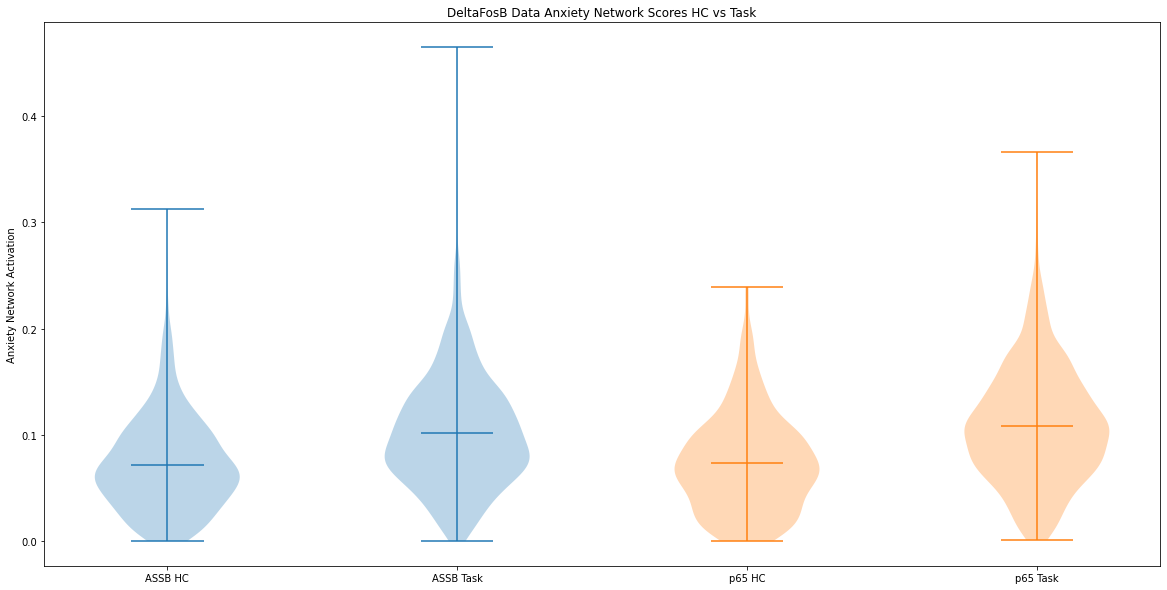

In [37]:
plt.figure(figsize=(20,10))
plt.violinplot((s_ASSB_hc[:,0],s_ASSB_task[:,0]),[1,2],
               points=1000,showmeans=True)
plt.violinplot((s_p65_hc[:500,0],s_p65_task[:,0]),[3,4],
               points=1000,showmeans=True)
plt.xticks([1,2,3,4],["ASSB HC","ASSB Task","p65 HC","p65 Task"])
plt.ylabel("Anxiety Network Activation")
plt.title("DeltaFosB Data Anxiety Network Scores HC vs Task")
plt.savefig("../Plots/DeltaFosB_Anxiety_Scores_Violin.png")
plt.show()

In [42]:
mw_auc_dict = umc_dt.lpne_auc(y_pred_ASSB,y_task[y_condition=="ASSB"].squeeze(),y_mouse[y_condition=="ASSB"],s[y_condition=="ASSB"],True)
mw_mean, mw_std = umc_dt.get_mean_std_err_auc(y_pred_ASSB,y_task[y_condition=="ASSB"].squeeze(),y_mouse[y_condition=="ASSB"],s[y_condition=="ASSB"],True)
print("ASSB hc vs task auc: {:.3} +/- {:.3}".format(mw_mean,mw_std))


mw_auc_dict = umc_dt.lpne_auc(y_pred_p65,y_task[y_condition=="p65"].squeeze(),y_mouse[y_condition=="p65"],s[y_condition=="p65"],True)
mw_mean, mw_std = umc_dt.get_mean_std_err_auc(y_pred_p65,y_task[y_condition=="p65"].squeeze(),y_mouse[y_condition=="p65"],s[y_condition=="p65"],True)
print("p65 hc vs task auc: {:.3} +/- {:.3}".format(mw_mean,mw_std))

ASSB hc vs task auc: 0.717 +/- 0.0332
p65 hc vs task auc: 0.696 +/- 0.0419


In [51]:
np.unique(y_condition=='ASSB')

array([False,  True])

In [56]:
mw_auc_dict = umc_dt.lpne_auc(y_pred[y_task==0],(y_condition=="ASSB")[y_task==0].squeeze(),np.ones(y_task.shape)[y_task==0],s[y_task==0],True)
mw_mean, mw_std = umc_dt.get_mean_std_err_auc(y_pred[y_task==0],(y_condition=="ASSB")[y_task==0].squeeze(),np.ones(y_task.shape)[y_task==0],s[y_task==0],True)
print("Homecage ASSB vs p65 auc: {:.3} +/- {:.3}".format(mw_mean,mw_std))
print(mw_auc_dict)

mw_auc_dict = umc_dt.lpne_auc(y_pred[y_task==1],(y_condition=="ASSB")[y_task==1].squeeze(),np.ones(y_task.shape)[y_task==1],s[y_task==1],True)
mw_mean, mw_std = umc_dt.get_mean_std_err_auc(y_pred[y_task==1],(y_condition=="ASSB")[y_task==1].squeeze(),np.ones(y_task.shape)[y_task==1],s[y_task==1],True)
print("Task ASSB vs p65 auc: {:.3} +/- {:.3}".format(mw_mean,mw_std))
print(mw_auc_dict)

Homecage ASSB vs p65 auc: 0.475 +/- nan
{'auc_method': 'mannWhitneyU', 1.0: (0.47488980088159294, 0.05298261807034495)}
Task ASSB vs p65 auc: 0.461 +/- nan
{'auc_method': 'mannWhitneyU', 1.0: (0.46137801403910567, 0.00023574620138651234)}


In [55]:
mw_auc_dict

{'auc_method': 'mannWhitneyU',
 1.0: (0.46137801403910567, 0.00023574620138651234)}

In [45]:
mw_auc_dict = umc_dt.lpne_auc(y_pred,y_task.squeeze(),y_mouse,s,True)
mw_mean, mw_std = umc_dt.get_mean_std_err_auc(y_pred,y_task.squeeze(),y_mouse,s,True)
print("by mouse hc vs task auc: {:.3} +/- {:.3}".format(mw_mean,mw_std))

auc_list = []
p_val_list = []

for mouse in y_mouse:
    auc_list.append(mw_auc_dict[mouse][0])
    p_val_list.append(mw_auc_dict[mouse][1])

saveDict = {
    "mouse":y_mouse,
    "sex":y_sex,
    "condition":y_condition,
    "in-task":y_task,
    "time":y_time,
    "expDate":y_expDate,
    "scores":s[:,0],
    "hc vs task auc": auc_list,
    "hc vs task pval": p_val_list,
    
}

df = pd.DataFrame.from_dict(saveDict)
df.to_csv(PROJECTION_SAVE_PATH + "MT_onto_DeltaFosB_EPM.csv")

by mouse hc vs task auc: 0.708 +/- 0.0248


In [46]:
df

,mouse,sex,condition,in-task,time,expDate,scores,hc vs task auc,hc vs task pval
0,Mouse28472,M,ASSB,False,1,092922,0.054421,0.687588,4.066576e-10
1,Mouse28472,M,ASSB,False,2,092922,0.081038,0.687588,4.066576e-10
2,Mouse28472,M,ASSB,False,3,092922,0.084458,0.687588,4.066576e-10
3,Mouse28472,M,ASSB,False,4,092922,0.088982,0.687588,4.066576e-10
4,Mouse28472,M,ASSB,False,5,092922,0.091198,0.687588,4.066576e-10
...,...,...,...,...,...,...,...,...,...
5011,Mouse95434,M,ASSB,True,714,090922,0.134535,0.693848,5.654730e-19
5012,Mouse95434,M,ASSB,True,715,090922,0.196755,0.693848,5.654730e-19
5013,Mouse95434,M,ASSB,True,716,090922,0.193021,0.693848,5.654730e-19
5014,Mouse95434,M,ASSB,True,717,090922,0.121735,0.693848,5.654730e-19
